In [24]:
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType, col
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.sql.functions import when

In [25]:
#Building session now
spark = SparkSession.builder.appName('deep_learning_with_spark').getOrCreate()


In [26]:
# Load each CSV file into a separate Spark DataFrame
df1 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2005_to_2007.csv', header=True, inferSchema=True)
df2 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2009_to_2011.csv', header=True, inferSchema=True)
df3 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2012_to_2014.csv', header=True, inferSchema=True)
#test = spark.read.csv('/mnt/bdpa23-group14-pvc/test100.csv', header=True, inferSchema=True)
# Combine the DataFrames into a single DataFrame
data = df1.union(df2).union(df3)

#data = test
#OLD_FILE: url = "https://raw.githubusercontent.com/Apress/learn-pyspark/master/chap_8/dl_data.csv"
#OLD_FILE: from pyspark import SparkFiles
#OLD_FILE: spark.sparkContext.addFile(url)

#OLD_FILE: = spark.read.csv("file://"+SparkFiles.get("dl_data.csv"), header=True, inferSchema= Tru
# test test atest test test test test test
print(data.count())

data = data.withColumn('Accident_Severity', when(data.Accident_Severity == 1, 0).otherwise(data.Accident_Severity))
data = data.withColumn('Accident_Severity', when(data.Accident_Severity == 2, 1).otherwise(data.Accident_Severity))
data = data.withColumn('Accident_Severity', when(data.Accident_Severity == 3, 2).otherwise(data.Accident_Severity))

1504150


In [27]:

new_data = data
new_data = new_data.drop("Junction_Detail")
new_data = new_data.drop("Junction_Control")
new_data = new_data.drop("Location_Easting_OSGR")
new_data = new_data.drop("Location_Northing_OSGR")
new_data = new_data.drop("Longitude")
new_data = new_data.drop("Latitude")
new_data = new_data.drop("Police_Force")
new_data = new_data.drop("Date")
# new_data = new_data.drop("Time")
new_data = new_data.drop("Local_Authority_(District)")
new_data = new_data.drop("Local_Authority_(Highway)")
new_data = new_data.drop("1st_Road_Class")
new_data = new_data.drop("1st_Road_Number")
new_data = new_data.drop("2nd_Road_Class")
new_data = new_data.drop("2nd_Road_Number")
new_data = new_data.drop("Pedestrian_Crossing-Human_Control")
new_data = new_data.drop("Pedestrian_Crossing-Physical_Facilities")
#new_data = new_data.drop("Light_Conditions")
#new_data = new_data.drop("Road_Surface_Conditions")
new_data = new_data.drop("Carriageway_Hazards")
#new_data = new_data.drop("Urban_or_Rural_Area")
new_data = new_data.drop("Did_Police_Officer_Attend_Scene_of_Accident")
new_data = new_data.drop("LSOA_of_Accident_Location")

new_data = new_data.drop("Road_Type")
new_data = new_data.drop("Special_Conditions_at_Site")
new_data = new_data.drop("Accident_Index")
new_data = new_data.dropna(how='any', thresh=None, subset=None)
print(new_data.count())

1501957


In [33]:
new_data.show(vertical=True)

-RECORD 0---------------------------------------
 label                   | 1                    
 Number_of_Vehicles      | 1.0                  
 Number_of_Casualties    | 1.0                  
 Day_of_Week             | 3.0                  
 Time                    | 17:42                
 Speed_limit             | 30.0                 
 Light_Conditions        | Daylight: Street ... 
 Weather_Conditions      | Raining without h... 
 Road_Surface_Conditions | Wet/Damp             
 Urban_or_Rural_Area     | 1.0                  
 Year                    | 2005.0               
-RECORD 1---------------------------------------
 label                   | 2                    
 Number_of_Vehicles      | 1.0                  
 Number_of_Casualties    | 1.0                  
 Day_of_Week             | 4.0                  
 Time                    | 17:36                
 Speed_limit             | 30.0                 
 Light_Conditions        | Darkness: Street ... 
 Weather_Conditions 

In [34]:
new_data.dtypes

[('label', 'int'),
 ('Number_of_Vehicles', 'double'),
 ('Number_of_Casualties', 'double'),
 ('Day_of_Week', 'double'),
 ('Time', 'string'),
 ('Speed_limit', 'double'),
 ('Light_Conditions', 'string'),
 ('Weather_Conditions', 'string'),
 ('Road_Surface_Conditions', 'string'),
 ('Urban_or_Rural_Area', 'double'),
 ('Year', 'double')]

In [35]:
new_data = new_data.withColumnRenamed("Accident_Severity", "label")
for i, column in zip(new_data.dtypes, new_data.columns):
    if i[1] == 'int' and i[0] != 'label':
        new_data = new_data.withColumn(column, col(column).cast("double"))

In [36]:
new_data.dtypes

[('label', 'int'),
 ('Number_of_Vehicles', 'double'),
 ('Number_of_Casualties', 'double'),
 ('Day_of_Week', 'double'),
 ('Time', 'string'),
 ('Speed_limit', 'double'),
 ('Light_Conditions', 'string'),
 ('Weather_Conditions', 'string'),
 ('Road_Surface_Conditions', 'string'),
 ('Urban_or_Rural_Area', 'double'),
 ('Year', 'double')]

In [37]:
train, validation, test = new_data.randomSplit([0.7, 0.2, 0.1], 1234)

In [38]:
categorical_columns = [item[0] for item in new_data.dtypes if item[1].startswith('string')]
numeric_columns = [item[0] for item in new_data.dtypes if item[1].startswith('double')]
indexers = [StringIndexer(inputCol=column, outputCol='{0}_index'.format(column)) for column in categorical_columns]

In [39]:
print(categorical_columns, numeric_columns)

['Time', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions'] ['Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week', 'Speed_limit', 'Urban_or_Rural_Area', 'Year']


In [40]:
featuresCreator = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numeric_columns, outputCol="features")


In [41]:
layers = [len(featuresCreator.getInputCols()), 4, 2, 3]
classifier = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', maxIter=100, layers=layers, blockSize=128, seed=1234)
print(classifier.getFeaturesCol())


features


In [42]:
pipeline = Pipeline(stages=indexers + [featuresCreator, classifier])
print(pipeline.explainParams())


stages: a list of pipeline stages (current: [StringIndexer_eefa4bbaf524, StringIndexer_4e952b98f8f9, StringIndexer_cc60e36433f7, StringIndexer_00ed6a7fda53, VectorAssembler_4e72f964936d, MultilayerPerceptronClassifier_35131ac99008])


In [48]:
model = pipeline.fit(train)

KeyboardInterrupt: 

In [44]:
train_output_df = model.transform(train)
validation_output_df = model.transform(validation)
test_output_df = model.transform(test)

In [45]:
train_predictionAndLabels = train_output_df.select("prediction", "label")
validation_predictionAndLabels = validation_output_df.select("prediction","label")
test_predictionAndLabels = test_output_df.select("prediction", "label")
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' +
    str(evaluator.evaluate(train_predictionAndLabels)))
    print('Validation ' + metric + ' = ' +
    str(evaluator.evaluate(validation_predictionAndLabels)))
    print('Test ' + metric + ' = ' +
    str(evaluator.evaluate(test_predictionAndLabels)))

Train weightedPrecision = 0.7241621096293491
Validation weightedPrecision = 0.7246831043134082
Test weightedPrecision = 0.7245346142138729
Train weightedRecall = 0.8509282815952297
Validation weightedRecall = 0.8513329448005994
Test weightedRecall = 0.8514408125675693
Train accuracy = 0.8509282815952297
Validation accuracy = 0.8513329448005994
Test accuracy = 0.8514408125675693


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
print(categorical_columns, numeric_columns)

['Time', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions'] ['Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week', 'Speed_limit', 'Urban_or_Rural_Area', 'Year']


In [21]:
#Get Class labels
class_temp = test_predictionAndLabels.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
print(class_temp)

   label   count
0      2  127743
1      1   20394
2      0    1893


In [22]:
#Calculate confusion matrix
from sklearn.metrics import confusion_matrix
y_true = test_predictionAndLabels.select("label")
y_true = y_true.toPandas()
y_pred = test_predictionAndLabels.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp['label'])
cnf_matrix


array([[127743,      0,      0],
       [ 20394,      0,      0],
       [  1893,      0,      0]])

Confusion matrix, without normalization
[[127743      0      0]
 [ 20394      0      0]
 [  1893      0      0]]


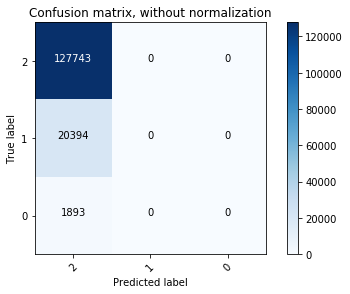

In [23]:
#Plotting Results
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp['label'].values, title='Confusion matrix, without normalization')
plt.show()